In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/duts-saliency-detection-dataset/metadata.csv
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00093064.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00045829.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00002009.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00034853.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00041462.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00007271.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/sun_aapcnnhiopaytrqx.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00070528.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00044119.jpg
/kaggle/input/duts-saliency-detection-dataset/DUTS-TE/DUTS-TE-Image/ILSV

In [6]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/kaggle/input/duts-saliency-detection-dataset/metadata.csv')
df=df.dropna()
df=df.drop_duplicates()
df=df.sample(1000)
def function(x):
    return '/kaggle/input/duts-saliency-detection-dataset/'+x
trainData=df[df['split']=='train']
testData=df[df['split']=='test']
trainData.drop(columns=['split','image_id'],inplace=True)
testData.drop(columns=['split','image_id'],inplace=True)
trainData=trainData.apply(function)
testData=testData.apply(function)
trainData.head()


<ipython-input-4-25d602d2b213>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainData.drop(columns=['split','image_id'],inplace=True)
<ipython-input-4-25d602d2b213>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData.drop(columns=['split','image_id'],inplace=True)


,image_path,mask_path
10985,/kaggle/input/duts-saliency-detection-dataset/...,/kaggle/input/duts-saliency-detection-dataset/...
11303,/kaggle/input/duts-saliency-detection-dataset/...,/kaggle/input/duts-saliency-detection-dataset/...
8721,/kaggle/input/duts-saliency-detection-dataset/...,/kaggle/input/duts-saliency-detection-dataset/...
12124,/kaggle/input/duts-saliency-detection-dataset/...,/kaggle/input/duts-saliency-detection-dataset/...
3753,/kaggle/input/duts-saliency-detection-dataset/...,/kaggle/input/duts-saliency-detection-dataset/...


## Creating DataSet<!--  -->

In [5]:
trainData = tf.data.Dataset.from_tensor_slices((trainData['image_path'].values, trainData['mask_path'].values))
testData = tf.data.Dataset.from_tensor_slices((testData['image_path'].values, testData['mask_path'].values))


In [9]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(100,100))
    img=img/255.0
    return img

def preprocess_twin(input_img,validation_img):
    return (preprocess(input_img),preprocess(validation_img))

In [10]:
trainData=trainData.map(preprocess_twin)
testData=testData.map(preprocess_twin)
trainData=trainData.batch(32)
testData=testData.batch(16)

## Model Building

In [11]:
class Adapter(tf.keras.Model):
    def __init__(self ,fil):
        super(Adapter, self).__init__()
        
        self.down = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=(2, 2),  
            padding='same'
        )
        
        self.up = tf.keras.layers.Conv2DTranspose(
            filters=fil,
            kernel_size=3,
            strides=(2,2),
            padding='same'
        )
        
        self.gelu = tf.keras.layers.Activation('gelu')

    def call(self, inputs):
        x = self.down(inputs)  
        x = self.gelu(x)
        x = self.up(x)      
        x = self.gelu(x)
        return x

        

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self,noFilters,i,fil):
        super(Encoder,self).__init__()
        self.adapter=Adapter(fil)
        self.norm=tf.keras.layers.LayerNormalization()
        self.mlp=tf.keras.layers.Conv2D(
            filters=noFilters,
            kernel_size=3,
            strides=(2**(i+1), 2**(i+1)), 
            padding='same'
        )
    def call(self,inputs):
        adapOutput=self.adapter(inputs)
        adapOutput = tf.image.resize(adapOutput, (inputs.shape[1], inputs.shape[2]))
        y=adapOutput+inputs
        y=self.norm(y)
        y=self.mlp(y)
        return y  

In [13]:
class RFB(tf.keras.Model):
    def __init__(self):
        super(RFB,self).__init__()
        self.mlp=tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=3, 
            padding='same'
        )
    def call(self,inputs):
        return self.mlp(inputs)

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder,self).__init__()
        self.upScale=tf.keras.layers.Conv2DTranspose(
            filters=64, 
            kernel_size=3, 
            strides=2, 
            padding='same')
        self.conv = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=3,
            padding='same'
        )
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.segmentationHead=tf.keras.layers.Conv2D(
            filters=1, 
            kernel_size=1,
            activation='sigmoid'
        )
    def call(self,downImage,upImage):
        x=self.upScale(downImage)
        x = tf.image.resize(x, (upImage.shape[1], upImage.shape[2]))
        x=tf.concat([upImage,x],axis=-1)
        x=self.conv(x)
        x=self.bn(x)
        x=self.relu(x)
        final=self.segmentationHead(x)
        final=tf.image.resize(final, (100, 100))
        return (final,x)

In [15]:
class SAM2UNET(tf.keras.Model):
    def __init__(self):
        super(SAM2UNET, self).__init__()
        self.Encoder1 = Encoder(144, 1,3)
        self.Encoder2 = Encoder(288, 2,144)
        self.Encoder3 = Encoder(576, 3,288)
        self.Encoder4 = Encoder(1152, 4,576)
        
        self.Decoder1 = Decoder()
        self.Decoder2 = Decoder()
        self.Decoder3 = Decoder()
        
        self.rfb1 = RFB()
        self.rfb2 = RFB()
        self.rfb3 = RFB()
        self.rfb4 = RFB()

    def call(self, inputs):
        encoder1 = self.Encoder1(inputs)
        encoder2 = self.Encoder2(encoder1)
        encoder3 = self.Encoder3(encoder2)
        encoder4 = self.Encoder4(encoder3)
        
        rfb4 = self.rfb4(encoder4)
        rfb3 = self.rfb3(encoder3)
        rfb2 = self.rfb2(encoder2)
        rfb1 = self.rfb1(encoder1)
        
        out3, decoder3 = self.Decoder3(rfb4, rfb3)
        out2, decoder2 = self.Decoder2(decoder3, rfb2)
        out1, decoder1 = self.Decoder1(decoder2, rfb1)
        
        return (out1, out2, out3)
        
        

In [16]:
def weightedIou(y_true, y_pred, weights=None):
    """Calculates weighted IoU Loss."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred * weights) if weights is not None else tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    iou_loss = 1 - (intersection + 1e-6) / (union + 1e-6)
    return iou_loss

def weightedBCE(y_true, y_pred, weights=None):
    """Calculates weighted BCE Loss."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    if weights is not None:
        loss = weights * tf.keras.losses.binary_crossentropy(y_true, y_pred)
    else:
        loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    return tf.reduce_mean(loss)

def totalLoss(y_true, outputs, weights=None):
    """Combines Weighted IoU Loss and Weighted BCE Loss for each segmentation output."""
    total_loss_value = 0
    for output in outputs:
        lw_iou = weightedIou(y_true, output, weights)
        lw_bce = weightedBCE(y_true, output, weights)
        total_loss_value += (lw_iou + lw_bce)
    return total_loss_value



## Model Training

In [48]:
epochs=100
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    0.001, len(trainData)*epochs, alpha=0.01, name='cosine_decay'
)
opt = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_scheduler)

model = SAM2UNET()


In [49]:
def train(batch):
    with tf.GradientTape() as tape:
        x=batch[0]
        y=batch[1]
        out1,out2,out3=model(x)
        loss=totalLoss(y,[out1,out2,out3])
    grad=tape.gradient(loss,model.trainable_weights)
    opt.apply_gradients(zip(grad,model.trainable_weights))
    return loss

In [50]:
def trainModel(data,epochs):
    for epoch in range(1,epochs+1):
        print("\n Epoch {}/{}".format(epoch,epochs))
        progbar=tf.keras.utils.Progbar(len(data))
        for idx,batch in enumerate(data):
            loss=train(batch)
            progbar.update(idx+1)
        print(loss)

    

    

In [51]:
trainModel(trainData,epochs)


 Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 499ms/step
tf.Tensor(3.6993148, shape=(), dtype=float32)

 Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step
tf.Tensor(3.6177454, shape=(), dtype=float32)

 Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step
tf.Tensor(3.57194, shape=(), dtype=float32)

 Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step
tf.Tensor(3.4096124, shape=(), dtype=float32)

 Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step
tf.Tensor(3.2273407, shape=(), dtype=float32)

 Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 501ms/step
tf.Tensor(3.1480365, shape=(), dtype=float32)

 Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 501ms/step
tf.Tensor(3.016851, shape=(), dtype=float32)

 Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 510ms/step
tf.Tensor(2.9861703, shape=(), dtype=float32)

 Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step
tf.Tensor(2.8618727, shape=(), dtype=float32)

 Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 513ms/step
tf.Tensor(2.6849213, shape=(

## Results<!--  -->

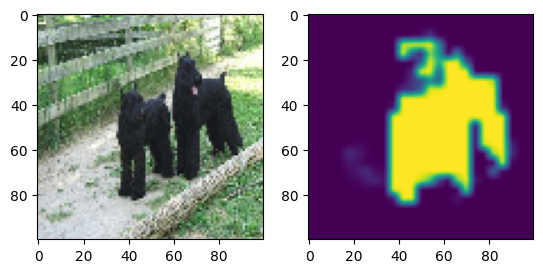

In [52]:
img = preprocess('/kaggle/input/duts-saliency-detection-dataset/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00088562.jpg')
expandImg = tf.expand_dims(img, axis=0)

out1, out2, out3 = model(expandImg)

output = out1[0]  

figure, axis = plt.subplots(1, 2)
axis[0].imshow(img.numpy())
axis[1].imshow(output.numpy())
plt.show()

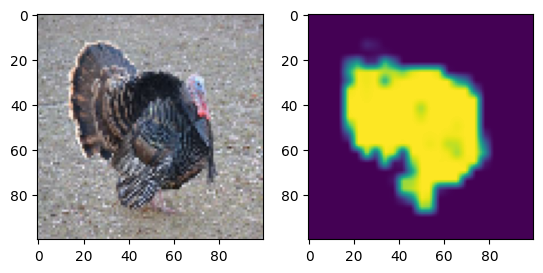

In [53]:
img = preprocess('/kaggle/input/duts-saliency-detection-dataset/DUTS-TR/DUTS-TR-Image/ILSVRC2013_test_00003246.jpg')
expandImg = tf.expand_dims(img, axis=0)

out1, out2, out3 = model(expandImg)

output = out1[0]  

figure, axis = plt.subplots(1, 2)
axis[0].imshow(img.numpy())
axis[1].imshow(output.numpy())
plt.show()

In [57]:
def testLoss(y_true, output, weights=None):
    """Combines Weighted IoU Loss and Weighted BCE Loss for each segmentation output."""
    lw_iou = weightedIou(y_true, output, weights)
    lw_bce = weightedBCE(y_true, output, weights)
    total_loss_value = (lw_iou + lw_bce)
    return total_loss_value

In [59]:
for idx,batch in enumerate(testData):
    out1,out2,out3=model(batch[0])
    print(testLoss(batch[1],out1))

tf.Tensor(2.4607801, shape=(), dtype=float32)
tf.Tensor(1.7445266, shape=(), dtype=float32)
tf.Tensor(1.8830101, shape=(), dtype=float32)
tf.Tensor(1.56282, shape=(), dtype=float32)
tf.Tensor(1.7593696, shape=(), dtype=float32)
tf.Tensor(2.3384047, shape=(), dtype=float32)
tf.Tensor(1.6756042, shape=(), dtype=float32)
tf.Tensor(1.6256344, shape=(), dtype=float32)
tf.Tensor(1.4409907, shape=(), dtype=float32)
tf.Tensor(1.383249, shape=(), dtype=float32)
tf.Tensor(1.6980507, shape=(), dtype=float32)
tf.Tensor(2.2498493, shape=(), dtype=float32)
tf.Tensor(1.9818293, shape=(), dtype=float32)
tf.Tensor(2.0745084, shape=(), dtype=float32)
tf.Tensor(1.7594857, shape=(), dtype=float32)
tf.Tensor(1.4675927, shape=(), dtype=float32)
tf.Tensor(1.575984, shape=(), dtype=float32)
tf.Tensor(1.4211998, shape=(), dtype=float32)
tf.Tensor(1.7079731, shape=(), dtype=float32)
tf.Tensor(1.9149647, shape=(), dtype=float32)
tf.Tensor(1.6723874, shape=(), dtype=float32)
tf.Tensor(1.5679127, shape=(), dtype=f